In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np
import torch

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

nback_t = torch.from_numpy(nback).float().cuda()
emoid_t = torch.from_numpy(emoid).float().cuda()

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [4]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

(620,)
(620, 2)
(620,)
Complete


In [78]:
import torch.nn as nn
import torch.nn.functional as F

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class TVEC(nn.Module):
    def __init__(self, inp, lambd=0, beta=1e0, beta2=1e0, dim=10, lag=1):
        super(TVEC, self).__init__()
        self.lag = lag
        self.N = inp.shape[0]
        self.R = inp.shape[1]
        self.T = inp.shape[2]-self.lag
#         self.base = torch.eye(n).float().cuda()
#         self.base = nn.Parameter(self.base)
        self.A = torch.randn(self.N,self.T,self.R,dim).float().cuda()/self.R
        self.A = nn.Parameter(self.A)
        self.lambd = lambd
        self.beta = beta
        self.beta2 = beta2
        self.dp = nn.Dropout(p=0.1)
#         self.eye = torch.eye(n).float().cuda()

    def predict(self, x, A):
        idx = torch.arange(264).long().cuda()
        w = torch.einsum('abc,adc->abd',A,A)
        w[:,idx,idx] = 0
        xhat = torch.einsum('abd,ba->da',w,x[:,:-self.lag])
        return xhat,w
        
    def forward(self, x):
        x = self.dp(x)
        xhat = torch.zeros(self.N,self.R,self.T).float().cuda()
        w = torch.zeros(self.N,264,264)
        diff2 = 0
        for sub in range(self.N):
            xhat[sub],w = self.predict(x[sub], self.A[sub])
            diff2 += self.beta2*torch.sum((w[:-1]-w[1:])**2)
        sim = torch.sum((xhat-x[:,:,self.lag:])**2)
        diff = 0 #self.beta*torch.sum((self.A-torch.mean(self.A, dim=(0,1)))**2)
        return [sim,diff,diff2]
    
nEpochs = 2000
pPeriod = 100

X = nback_t[0:20]

tvec = TVEC(X,lambd=0,beta=1e0,beta2=1e0,dim=10,lag=1)
optim = torch.optim.Adam(tvec.parameters(), lr=1e-4, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-6)

for epoch in range(nEpochs):
    loss = tvec(X)
    sum(loss).backward()
    optim.step()
    sched.step(loss[0])
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {[float(part) for part in loss]} lr: {sched._last_lr}')
        
print('Complete')

0 [9155.0029296875, 0.0, 1.3111904859542847] lr: [0.0001]
100 [5841.603515625, 0.0, 789.2057495117188] lr: [0.0001]
200 [3627.298828125, 0.0, 2501.6220703125] lr: [0.0001]
300 [4173.470703125, 0.0, 2002.8377685546875] lr: [6.983372960937497e-05]
400 [4547.75390625, 0.0, 1508.3494873046875] lr: [4.4012666865176535e-05]
500 [4411.6416015625, 0.0, 1378.815673828125] lr: [2.7738957312183373e-05]
600 [4184.4697265625, 0.0, 1362.0423583984375] lr: [1.9371148445850086e-05]
700 [3937.85986328125, 0.0, 1399.6976318359375] lr: [1.9371148445850086e-05]
800 [3771.097412109375, 0.0, 1498.0950927734375] lr: [1.9371148445850086e-05]
900 [3660.404052734375, 0.0, 1578.599365234375] lr: [1.9371148445850086e-05]
1000 [3633.28173828125, 0.0, 1595.7542724609375] lr: [1.9371148445850086e-05]
1100 [3661.7197265625, 0.0, 1559.173095703125] lr: [1.9371148445850086e-05]
1200 [3693.357177734375, 0.0, 1496.1859130859375] lr: [1.9371148445850086e-05]
1300 [3734.59765625, 0.0, 1434.659912109375] lr: [1.937114844585

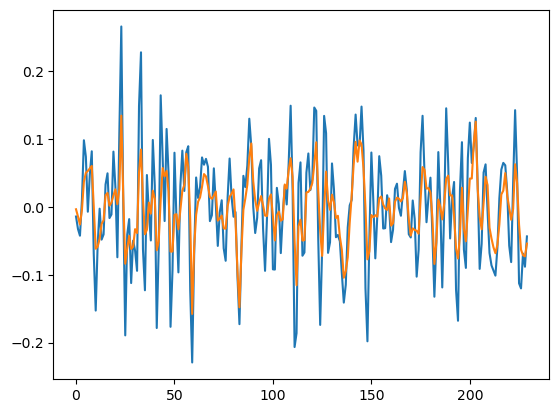

In [75]:
import matplotlib.pyplot as plt

sub = 6
roi = 74

with torch.no_grad():
    xhat,w = tvec.predict(X[sub], tvec.A[sub])
    xhat = xhat.detach().cpu().numpy()

plt.plot(X[sub,roi,1:].detach().cpu().numpy())
plt.plot(xhat[roi])
plt.show()

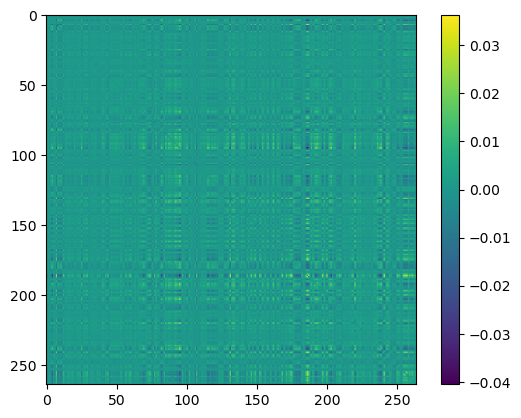

In [77]:
plt.imshow(w[10].detach().cpu().numpy())
plt.colorbar()
plt.show()

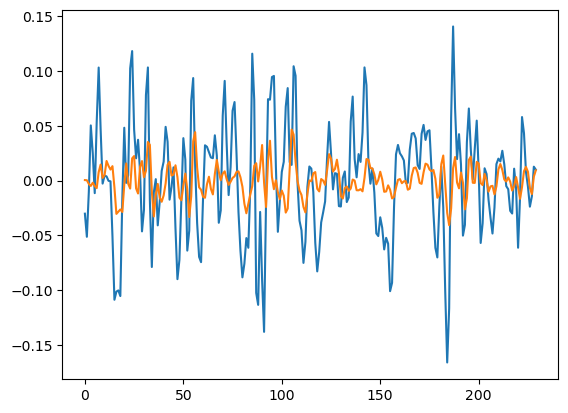

In [18]:
# Not low rank! The previous is rank 10, this is rank 264
# lstsq can do much better with recon (20 subj) but with alpha=0 
# and the weights look nothing like conn matrices (striped in one dimension)
# On the other hand, gradient descent gets to individualize matrices (but is constrained by rank 10)

nt = X.shape[2]
alpha = 1e2

A = X[:,:,:-1].permute(0,2,1).reshape(-1,264)
B = X[:,:,1:].permute(0,2,1).reshape(-1,264)

B1 = A.T@B
A1 = A.T@A+alpha*torch.eye(264).float().cuda()

w,_,_,_ = torch.linalg.lstsq(A1,B1)

sub = 0
roi = 4

Bhat = A@w

Bhat = Bhat.reshape(20,nt-1,264).permute(0,2,1)
B = B.reshape(20,nt-1,264).permute(0,2,1)

plt.plot(B[sub,roi].detach().cpu().numpy())
plt.plot(Bhat[sub,roi].detach().cpu().numpy())
plt.show()


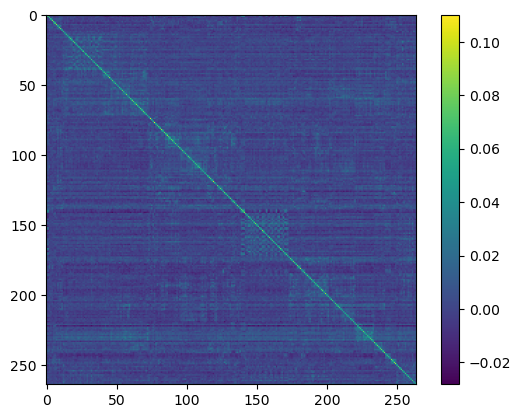

In [19]:
plt.imshow(w.detach().cpu().numpy())
plt.colorbar()
plt.show()